In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/drowsy-detection-dataset/Drowsy_datset/test/DROWSY/815.png
/kaggle/input/drowsy-detection-dataset/Drowsy_datset/test/DROWSY/491.png
/kaggle/input/drowsy-detection-dataset/Drowsy_datset/test/DROWSY/718.png
/kaggle/input/drowsy-detection-dataset/Drowsy_datset/test/DROWSY/709.png
/kaggle/input/drowsy-detection-dataset/Drowsy_datset/test/DROWSY/379.png
/kaggle/input/drowsy-detection-dataset/Drowsy_datset/test/DROWSY/780.png
/kaggle/input/drowsy-detection-dataset/Drowsy_datset/test/DROWSY/248.png
/kaggle/input/drowsy-detection-dataset/Drowsy_datset/test/DROWSY/480.png
/kaggle/input/drowsy-detection-dataset/Drowsy_datset/test/DROWSY/236.png
/kaggle/input/drowsy-detection-dataset/Drowsy_datset/test/DROWSY/630.jpg_0.png
/kaggle/input/drowsy-detection-dataset/Drowsy_datset/test/DROWSY/771.png
/kaggle/input/drowsy-detection-dataset/Drowsy_datset/test/DROWSY/675.png
/kaggle/input/drowsy-detection-dataset/Drowsy_datset/test/DROWSY/340.png
/kaggle/input/drowsy-detection-dataset/Drowsy

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os


IMAGE_DIMS = (96, 96)
FRAME_COUNT = 8
BATCH = 4

data_augmentor = ImageDataGenerator(rescale=1./255)
test_augmentor = ImageDataGenerator(rescale=1./255)

train_data = data_augmentor.flow_from_directory(
    "/kaggle/input/drowsy-detection-dataset/Drowsy_datset/train",
    target_size=IMAGE_DIMS,
    batch_size=1, 
    class_mode="binary",
    shuffle=True
)

eval_data = test_augmentor.flow_from_directory(
    "/kaggle/input/drowsy-detection-dataset/Drowsy_datset/test",
    target_size=IMAGE_DIMS,
    batch_size=1,  
    class_mode="binary",
    shuffle=False
)

def sequence_generator(data_stream, frame_count):
    frame_sequence, labels = [], []
    
    while True:
        for img, label in data_stream:
            frame_sequence.append(img[0])
            labels.append(label[0])
            
            if len(frame_sequence) == frame_count:
                yield np.array(frame_sequence).reshape(1, frame_count, IMAGE_DIMS[0], IMAGE_DIMS[1], 3), np.array(labels[-1]).reshape(1, 1)
                frame_sequence, labels = [], []  

train_sequence = sequence_generator(train_data, FRAME_COUNT)
eval_sequence = sequence_generator(eval_data, FRAME_COUNT)

feature_extractor = MobileNetV2(input_shape=(IMAGE_DIMS[0], IMAGE_DIMS[1], 3), include_top=False, weights='imagenet')
feature_extractor.trainable = False  

model = Sequential([
    TimeDistributed(feature_extractor, input_shape=(FRAME_COUNT, IMAGE_DIMS[0], IMAGE_DIMS[1], 3)),
    TimeDistributed(GlobalAveragePooling2D()),
    LSTM(32),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

stopping_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_adjuster = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)

model.fit(train_sequence,
          validation_data=eval_sequence,
          epochs=15,
          steps_per_epoch=len(train_data) // FRAME_COUNT,
          validation_steps=len(eval_data) // FRAME_COUNT,
          callbacks=[stopping_early, lr_adjuster])


Found 5859 images belonging to 2 classes.
Found 1483 images belonging to 2 classes.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_4 (TimeDistributed) │ (None, 8, 3, 3, 1280)       │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 8, 1280)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │         168,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,427,137 (9.26 MB)

 Trainable params: 169,153 (660.75 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/15
732/732 ━━━━━━━━━━━━━━━━━━━━ 88s 70ms/step - accuracy: 0.6369 - loss: 0.6330 - val_accuracy: 0.9405 - val_loss: 0.2317 - learning_rate: 5.0000e-04
Epoch 2/15
732/732 ━━━━━━━━━━━━━━━━━━━━ 42s 57ms/step - accuracy: 0.8418 - loss: 0.3414 - val_accuracy: 0.8270 - val_loss: 0.3217 - learning_rate: 5.0000e-04
Epoch 3/15
732/732 ━━━━━━━━━━━━━━━━━━━━ 42s 57ms/step - accuracy: 0.9057 - loss: 0.2718 - val_accuracy: 0.9459 - val_loss: 0.1506 - learning_rate: 5.0000e-04
Epoch 4/15
732/732 ━━━━━━━━━━━━━━━━━━━━ 42s 58ms/step - accuracy: 0.9390 - loss: 0.1798 - val_accuracy: 0.9459 - val_loss: 0.1307 - learning_rate: 5.0000e-04
Epoch 5/15
732/732 ━━━━━━━━━━━━━━━━━━━━ 43s 58ms/step - accuracy: 0.9266 - loss: 0.1880 - val_accuracy: 0.9459 - val_loss: 0.2255 - learning_rate: 5.0000e-04
Epoch 6/15
732/732 ━━━━━━━━━━━━━━━━━━━━ 43s 59ms/step - accuracy: 0.9236 - loss: 0.2027 - val_accuracy: 0.9351 - val_loss: 0.1758 - learning_rate: 5.0000e-04
Epoch 7/15
732/732 ━━━━━━━━━━━━━━━━━━━━ 42s 58ms/ste

In [7]:
model.save("CNN_LSTM.h5")

Enter the path to the image:  /kaggle/input/sleepface/good-sleep-habits-tips.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


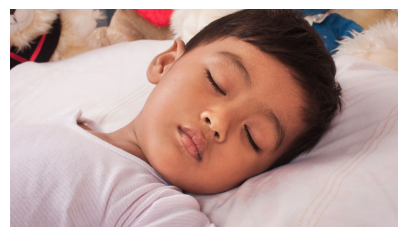

🔹 Prediction: Asleep (Confidence: 94.81%)


In [9]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

sleep_detection_model = tf.keras.models.load_model("CNN_LSTM.h5")
status_labels = ["Asleep", "Awake"]

def analyze_image(img_path):
    processed_img = image.load_img(img_path, target_size=(96, 96))
    img_array = image.img_to_array(processed_img) / 255.0

    img_sequence = np.array([img_array] * 8)
    img_sequence = np.expand_dims(img_sequence, axis=0)

    result = sleep_detection_model.predict(img_sequence)[0][0]
    predicted_label = status_labels[int(result > 0.5)]
    confidence_score = result if result > 0.5 else 1 - result

    img_display = cv2.imread(img_path)
    img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(5, 5))
    plt.imshow(img_display)
    plt.axis("off")
    plt.show()

    print(f"🔹 Prediction: {predicted_label} (Confidence: {confidence_score:.2%})")

img_path = input("Enter the path to the image: ").strip()
analyze_image(img_path)


Enter the path to the image:  /kaggle/input/awaketest/awake.jpeg


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


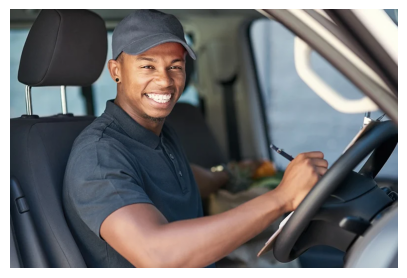

🔹 Prediction: Awake (Confidence: 59.85%)


In [10]:
sleep_detection_model = tf.keras.models.load_model("CNN_LSTM.h5")
status_labels = ["Asleep", "Awake"]

def analyze_image(img_path):
    processed_img = image.load_img(img_path, target_size=(96, 96))
    img_array = image.img_to_array(processed_img) / 255.0

    img_sequence = np.array([img_array] * 8)
    img_sequence = np.expand_dims(img_sequence, axis=0)

    result = sleep_detection_model.predict(img_sequence)[0][0]
    predicted_label = status_labels[int(result > 0.5)]
    confidence_score = result if result > 0.5 else 1 - result

    img_display = cv2.imread(img_path)
    img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(5, 5))
    plt.imshow(img_display)
    plt.axis("off")
    plt.show()

    print(f"🔹 Prediction: {predicted_label} (Confidence: {confidence_score:.2%})")

img_path = input("Enter the path to the image: ").strip()
analyze_image(img_path)
